In [30]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [27]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.6 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 3.09    
alpha = 9 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
l = 25
qBase = np.array([[23,20], [23-(np.sqrt(2)*l/2), 20-(np.sqrt(2)*l/2)], [27,20], [27+(np.sqrt(2)*l/2), 20-(np.sqrt(2)*l/2)],
                  [25, 20+2*np.sqrt(2)], [25,20+2*np.sqrt(2) + l]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

In [18]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [21]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, region, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
%store trismall_pcs
print(prob_pred_con)

Drawing 1250 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6
Stored 'trismall_pcs' (list)
[0.7602523659305994, 0.423841059602649, 0.7002314814814815]


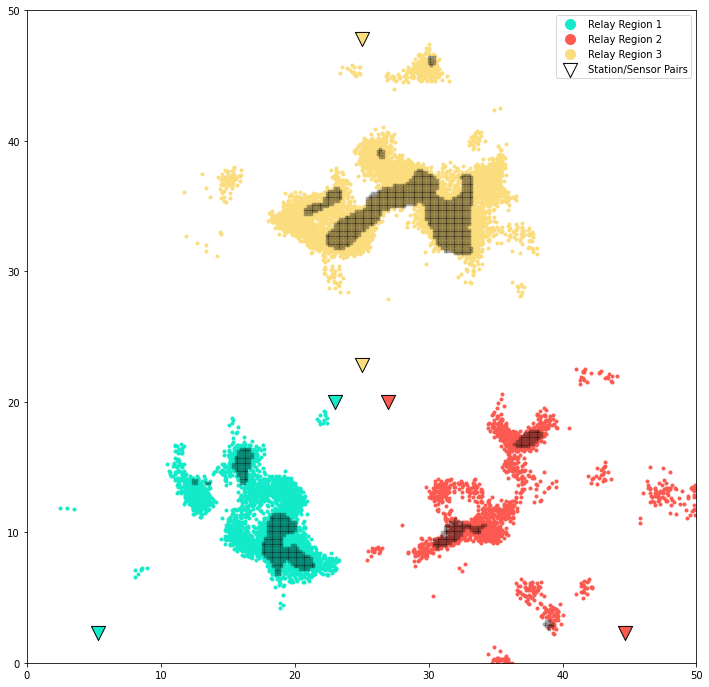

In [22]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [28]:
reload(sim)
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.2/beta, 0.01/beta]
dt_sys, AORP = sim.setup_polling_sys(pcs, els, beta, GAMMA_TH, p_th=p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
19 total subregions


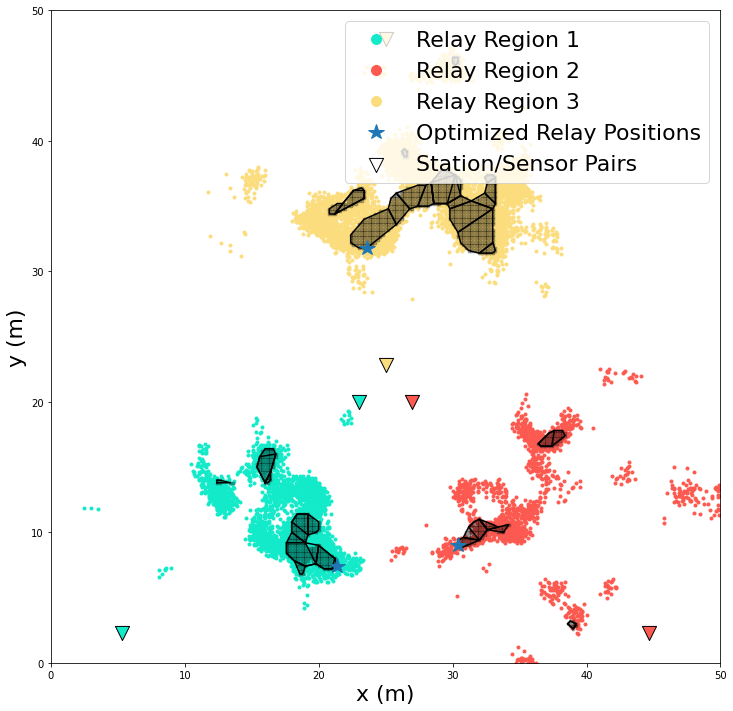

In [29]:
reload(sim)
sim.plot_AORP(dt_sys, AORP, tjcps, pjcps, qBase, region)

In [31]:
reload(sim)
motion_power = motion.LinearMotionPower(7.2, 0.29)
hrs = 1; mins = 0; seconds = 0;
ps = dt_sys.ps
AORP_res, AORP_xt, cyrp_res, cyrp_xt, rtable_res, rtable_xt = sim.run_sims(ps, AORP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W)

Average Data In/Out: 8.16
MB serviced in 1 hr: 29376.0
Average Power (W): 3.7211000000000003
Energy Consumption Over 1 Hr (J)13395.960000000001
	Thr		AORP		Cyclical	Table
WT (s):	25.46		27.19		43.46		24.16
E (J):	13395.96	13519.59	13566.42	13501.34
MB:	29376.00	29161.97	29063.77	29205.65


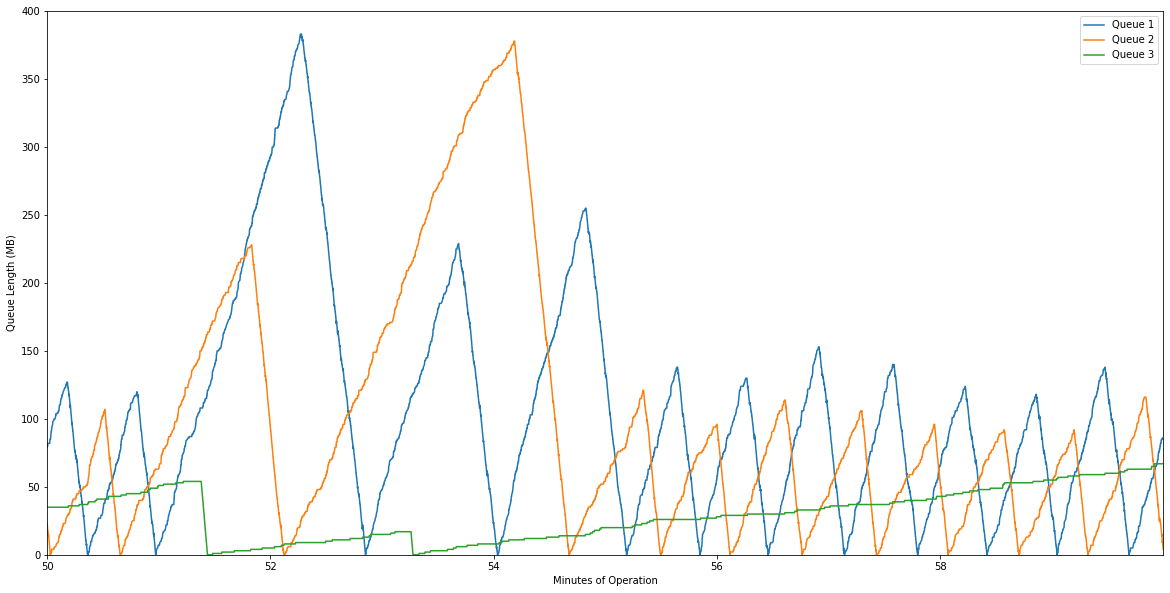

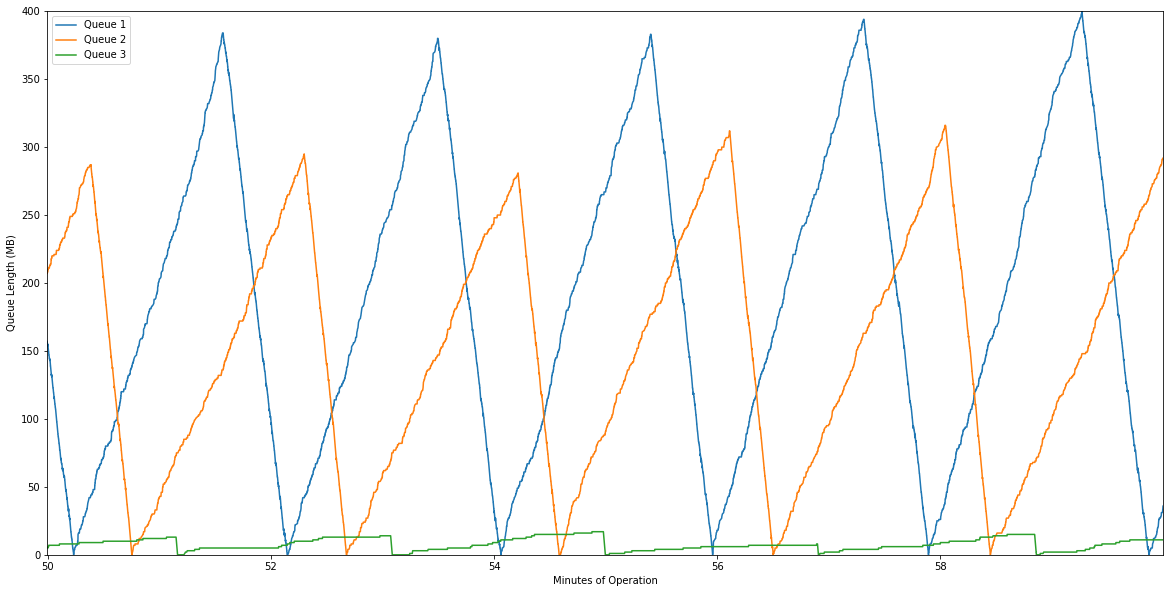

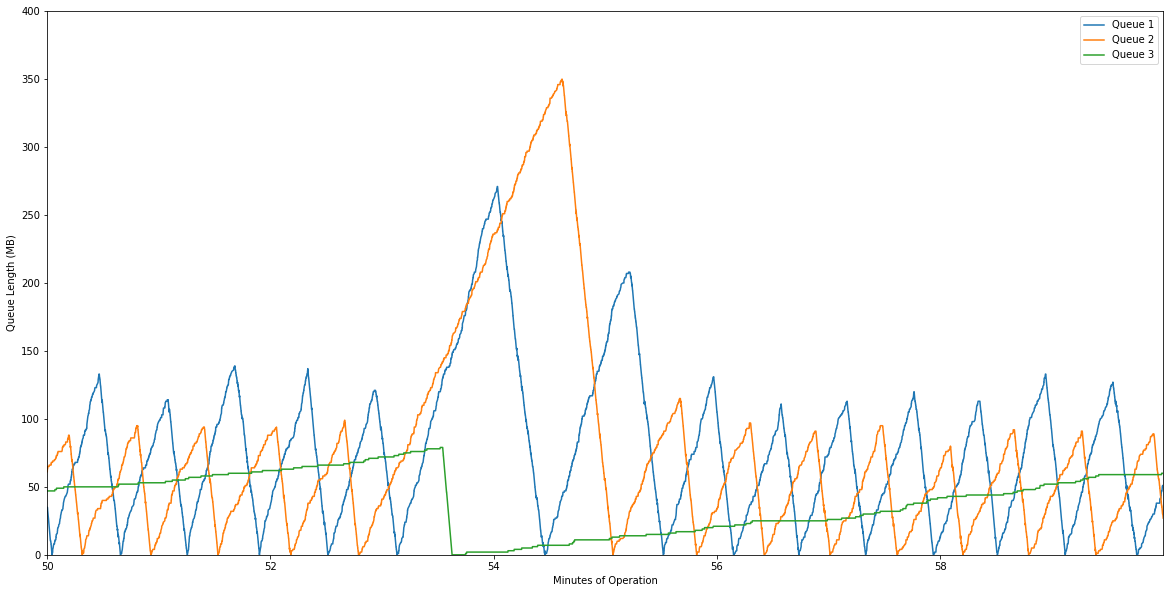

In [37]:
reload(sim)
sim.plotLast10Min(AORP_xt)
sim.plotLast10Min(cyrp_xt)
sim.plotLast10Min(rtable_xt)